In [24]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

means_data = pd.read_csv("Data/mean_matrix.csv")

wages = means_data[means_data["alder"] <= 61]["hourly_salary_Mean"].to_numpy()
hours = means_data[means_data["alder"] <= 61]["yearly_hours_Mean"].to_numpy() / 1924


In [25]:
means_data

,alder,hourly_salary_Mean,yearly_hours_Mean,formue_2018_Mean,pension_2018_Mean
0,30,209.123984,1216.018911,1.390663e+05,93931.941637
1,31,213.550100,1252.085171,1.583045e+05,114037.097150
2,32,218.416041,1278.155460,1.822347e+05,137705.065480
3,33,222.420283,1297.690952,1.975979e+05,159129.583760
4,34,225.728590,1304.994352,2.209879e+05,180924.953100
...,...,...,...,...,...
65,95,NaN,2.216195,1.071996e+06,40998.185185
66,96,NaN,1.013109,1.069632e+06,33700.733025
67,97,NaN,0.169537,1.063082e+06,34060.954333
68,98,NaN,0.260151,1.074022e+06,27895.346444


In [44]:
def sum_hours(t, hours, delta):
    total = np.sum(hours[:12])
    for i in range(t):
        total += (1 - delta) ** i * hours[t - i]
    return total

def objective_function(params, wages, hours):
    w, beta1, beta2, delta = params
    total_error = 0
    for t in range(len(wages)):
        error = (
            np.log(wages[t])
            - np.log(w)
            - beta1 * (sum_hours(t, hours, delta))
            - beta2 * t**2
        )
        total_error += error ** 2
    return total_error

initial_guess = [200, 0.02, -0.001, 0.05]
bounds = [(0.001, 300), (0, 100), (-10, 0), (0, 0.15)]

def random_initial_guess(bounds):
    # np.random.seed(1)
    return [np.random.uniform(low, high) for low, high in bounds]

# initial_guess = random_initial_guess(bounds)


result = minimize(
    objective_function,
    x0=initial_guess,
    args=(wages, hours),
    method="Nelder-Mead",
    bounds=bounds,
    tol=1e-12,
    options={
        "maxiter": 100000,  # Maximum iterations
        "xatol": 1e-12,
        "fatol": 1e-12, 
        "disp": True
    }
)


estimated_params = result.x
w_est, beta1_est, beta2_est, delta_est = estimated_params

results_dict = {
    "Parameter": ["w", "beta1", "beta2", "delta"],
    "Estimated Value": [w_est, beta1_est, beta2_est, delta_est],
}

results_df = pd.DataFrame(results_dict)

print(results_df)

print(result.fun)

Optimization terminated successfully.
         Current function value: 0.000478
         Iterations: 388
         Function evaluations: 727
  Parameter  Estimated Value
0         w       156.600466
1     beta1         0.034810
2     beta2        -0.000227
3     delta         0.056530
0.00047811790682008605


In [ ]:
np.sum(hours[:12])

np.float64(8.248157725675675)

In [ ]:
np.sum(hours[:12])

np.float64(8.248157725675675)

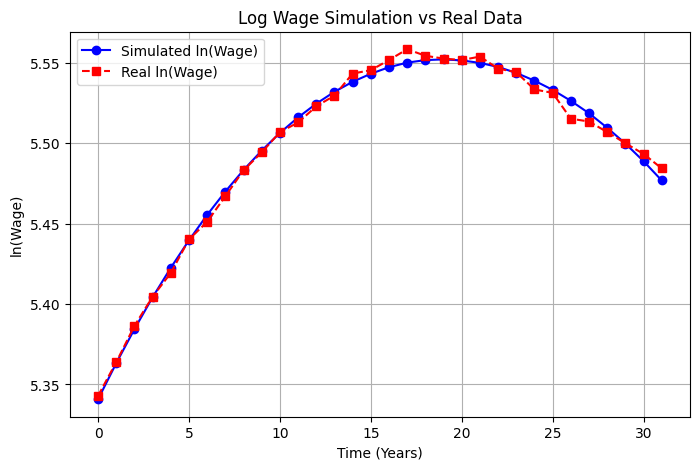

In [21]:
def simulate(params, wages, hours):
    w, beta1, beta2, delta = params
    ln_wage = np.zeros(len(wages))
    for t in range(len(wages)):
        ln_wage[t] = (
            np.log(w)
            + beta1 * (sum_hours(t, hours, delta))
            + beta2 * t**2
        )

    return ln_wage


ln_wage = simulate(estimated_params, wages, hours)


import matplotlib.pyplot as plt

def plot_ln_wage(ln_wage, man_hourly_salary, title="Log Wage Simulation vs Real Data", 
                 xlabel="Time (Years)", ylabel="ln(Wage)"):
    plt.figure(figsize=(8, 5))
    
    # Convert real hourly salary to log scale for comparison
    ln_real_wage = np.log(man_hourly_salary)
    
    # Plot simulated ln_wage
    plt.plot(ln_wage, marker="o", linestyle="-", label="Simulated ln(Wage)", color='b')
    
    # Plot real ln(wage)
    plt.plot(ln_real_wage, marker="s", linestyle="--", label="Real ln(Wage)", color='r')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_ln_wage(ln_wage, wages)